In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import sys
sys.path.insert(0,'..')
from functions import getRad, lowPass, mean_mask

In [2]:
lp = '/scratch-shared/janssens/eurec4a_mean'
sp = lp+'/figs'

klp = 4
qlc = 1e-7

ds = nc.Dataset(lp+'/cape2d.001.nc')

time  = np.ma.getdata(ds.variables['time'][:]) / 3600
xf    = np.ma.getdata(ds.variables['xt'][:]) # Cell centres (f in mhh)
xh    = np.ma.getdata(ds.variables['xm'][:]) # Cell edges (h in mhh)
yf    = np.ma.getdata(ds.variables['yt'][:]) # Cell centres (f in mhh)
yh    = np.ma.getdata(ds.variables['ym'][:]) # Cell edges (h in mhh)

extent = np.array([xf.min(), xf.max(), xf.min(), xf.max()])/1000

circ_mask = np.zeros((xf.size,xf.size))
rad = getRad(circ_mask)
circ_mask[rad<=klp] = 1

/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


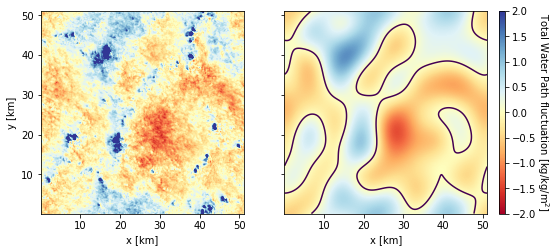

In [4]:
#%% Plot twp, twppf and clouds at a single time step

tPlot = 24

it = np.argmin(abs(tPlot-time))

# Albedo
qli = np.ma.getdata(ds.variables['lwp'][it,:,:])
# tau = 0.19*qli**(5./6)*7e7**(1/3)
# alb = tau/(6.8+tau)
alb = qli.copy()
alb[qli<qlc] = 0
alb[qli>=qlc] = 1

# TWP fluctuation
twpp = np.ma.getdata(ds.variables['twp'][it,:,:])
twpp -= np.mean(twpp)

# Low-pass filtered TWP fluctuation
twppf = lowPass(twpp, circ_mask)

fig,axs = plt.subplots(ncols=2,figsize=(8,4),sharey=True)
sc = axs[0].imshow(twpp,extent=extent,vmin=-2,vmax=2,cmap='RdYlBu')
axs[0].set_xlabel('x [km]')
axs[0].set_ylabel('y [km]')

axs[1].imshow(twppf,extent=extent,vmin=-2,vmax=2,cmap='RdYlBu')
axs[1].contour(twppf,levels=[0],extent=extent,origin='upper')
axs[1].set_xlabel('x [km]')

# axs[2].contour(twppf,levels=[0],extent=extent,origin='upper',colors='white')
# axs[2].imshow(alb,extent=extent,vmin=0,vmax=1,cmap='gist_gray')
# axs[2].set_xlabel('x [km]')

pos1 = axs[1].get_position()
cbax = fig.add_axes([.92, pos1.ymin, 0.01, pos1.height])
# cbax = fig.add_axes([1, 0.1, 0.02, 0.85])
# cbax = fig.add_axes([-0.06, 0.1, 0.02, 0.85])
cb = fig.colorbar(sc, cax=cbax)
cb.ax.set_ylabel(r"Total Water Path fluctuation [kg/kg/m$^2$]", rotation=270, labelpad=15) #-65
# plt.tight_layout()
plt.savefig(sp+'/twpfluct.pdf',bbox_inches='tight',dpi=300)

/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
No handles with labels found to put in legend.


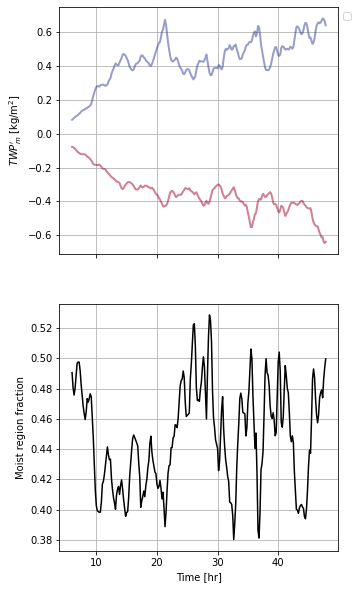

In [14]:
#%% Plot time evolution of twp, for a number of simulations

alpha=0.5
lw=2
col_moist = plt.cm.RdYlBu(0.99)
col_dry = plt.cm.RdYlBu(0)

tmin = 6.
tmax = 48.

itpltmin = np.where(time>=tmin)[0][0]
itpltmax = np.where(time<tmax)[0][-1]+1
plttime_var = np.arange(itpltmin,itpltmax,1)

fig, axs = plt.subplots(nrows=2,figsize=(5,10),sharex=True)

twppf_moist = np.zeros(len(plttime_var))
twppf_dry = np.zeros(len(plttime_var))
frac_moist = np.zeros(len(plttime_var))
for j in range(len(plttime_var)):
    twpp = np.ma.getdata(ds.variables['twp'][plttime_var[j],:,:])
    twpp -= np.mean(twpp)
    twppf = lowPass(twpp, circ_mask)
    mask_moist = np.zeros(twppf.shape)
    mask_moist[twppf > 0] = 1
    mask_dry = 1 - mask_moist
    frac_moist[j] = np.sum(mask_moist) / np.size(mask_moist)

    twppf_moist[j] = mean_mask(twppf, mask_moist)
    twppf_dry[j] = mean_mask(twppf, mask_dry)

axs[0].plot(time[plttime_var],twppf_moist,c=col_moist,lw=lw,alpha=alpha)
axs[0].plot(time[plttime_var],twppf_dry,c=col_dry,lw=lw,alpha=alpha)
axs[1].set_xlabel('Time [hr]')
axs[0].set_ylabel(r"$TWP_m'$ [kg/m$^2$]")
axs[0].legend(loc='upper left',bbox_to_anchor=(1,1))
axs[0].grid()

axs[1].plot(time[plttime_var], frac_moist, c='k')
axs[1].set_ylabel('Moist region fraction')
axs[1].grid()
plt.savefig(sp+'/twp_evo.pdf',bbox_inches='tight')